# Practice 3: Privacy of Frogs and Horses
We launch a Membership Inference Attack (MIA) against a binary classification model that distinguishes frogs and horses (from CIFAR10).
We implement LiRA (Likelihood Ratio Attack) as a MIA, compute the average privacy across all samples, and also identify the most vulnerable sample.
We show that that two are quite different and it's dangerous to report only average-case privacy metrics.
Then, we train the model with DP-SGD to guarantee Differentially Privacy. Finally, we show some guideline how to set $\varepsilon$ by computing
the TPR-FPR of the best MIA against any DP algorithm assuming the strongest (theoretical) adversary.

In [1]:
import torch
import numpy as np

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

MODEL_DIR = "./models/"

criterion = torch.nn.BCEWithLogitsLoss()

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU, "mps" for Apple Silicon, or "cpu" to train w/o GPU

SHADOW_MODEL_NUM = 50
BATCH_SIZE = 64
EPOCH_NUM = 10

print(
    f"Training on {DEVICE} using PyTorch {torch.__version__}"
)

Training on cuda using PyTorch 2.3.0+cu121


## Simple CNN model to distinguish two CIFAR classes
10 classes need more complex model.
The attack works better for more complex problems and when the base and target samples are more similar.

In [2]:
import torch.nn as nn
from torchvision import datasets
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # return_indices is only needed for Apple Silicon
        self.pool= nn.MaxPool2d(2, 2, return_indices=True)
        self.bn1=nn.BatchNorm2d(32)
        self.bn2=nn.BatchNorm2d(64)
        self.bn3=nn.BatchNorm2d(128)
        self.bn4=nn.BatchNorm2d(256)

        self.conv1 = nn.Conv2d(3, 32, 3,padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3,padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3,padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
                
        self.fc1 = nn.Linear(256 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 1)
                
        self.dropout = nn.Dropout(p=.50)

    def forward(self, x):
        x, _ = self.pool(F.relu(self.bn1(self.conv1(x))))
        x, _ = self.pool(F.relu(self.bn2(self.conv2(x))))
        x, _ = self.pool(F.relu(self.bn3(self.conv3(x))))
        x, _ = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x=self.fc3(x)
        return x


## Training, testing, selection and plotting

In [3]:
#from tqdm.notebook import tqdm
from tqdm import tqdm
import torch
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def select_classes(dataset, class1, class2):
    dataset.targets = np.array(dataset.targets)
    dataset.data = np.array(dataset.data)
    
    idxs1 = np.where(np.isin(dataset.targets, class1))[0]
    idxs1 = np.random.choice(idxs1, len(idxs1) // 2, replace=False)
   
    idxs2 = np.where(np.isin(dataset.targets, class2))[0]
    idxs2 = np.random.choice(idxs2, len(idxs2) // 2, replace=False)

    # binarize label 
    dataset.targets = np.array([x in class2 for x in dataset.targets])  
   
    return idxs1, idxs2

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# evaluate the network on the entire test set
def test(net, test_loader, criterion, device = DEVICE):
    """Evaluate the network on the entire test set."""
    total, correct, loss = 0, 0, 0
    net.eval()
    with torch.no_grad():
        for _, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            output = net(inputs)
            loss += criterion(output, targets).item()  # sum up batch loss
            correct += (torch.round(torch.sigmoid(output)) == targets).sum().item()    
            total += targets.size(0)
            
    return correct / total, loss / total

# train a given model for a given number of epochs with a given loss function
def train(net, train_loader, epochs, criterion, device = DEVICE, optimizer=None):
    """Train the network on the training set."""    
    if optimizer is None:
        optimizer = torch.optim.Adam(net.parameters())
    net.train()
    epoch_loss = 0.0
    
    correct = 0
    batch_num = len(train_loader)
    with tqdm(unit="batch", total=epochs * batch_num) as tepoch:
        for epoch in range(epochs):
            tepoch.set_description(f"Training epoch {epoch}")
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = net(inputs)

                loss = criterion(outputs, targets)

                correct = (torch.round(torch.sigmoid(outputs.detach())) == targets.detach()).sum().item()
                accuracy = correct / BATCH_SIZE

                loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss=loss.item(), accuracy=accuracy)

                epoch_loss += loss.item()
                tepoch.update(1)

def train_shadow_models(training_data, criterion, shadow_model_num, data_ratio=0.5, file_prefix="shadow", device = DEVICE):
    for i in range(shadow_model_num):
        print(f"Training shadow model {i}")
        idxs = np.random.choice(len(training_data), int(len(training_data) * data_ratio), replace=False)
        train_loader = torch.utils.data.DataLoader(Subset(training_data, idxs), batch_size=BATCH_SIZE, shuffle=True)

        net = Net().to(device)
        net.train()
        train(net, train_loader, EPOCH_NUM, criterion, device)

        torch.save(net.state_dict(), f"{MODEL_DIR}shadow_model_{i}.pth")
        np.save(f"{MODEL_DIR}shadow_idxs_{i}.npy", idxs)
    

def show_images(samples, title):
    plt.figure()
    samples = samples.cpu()
    grid = make_grid(samples)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title(title)
    plt.show()


## Preparation: Select target sample whose membership should be inferred


In [4]:
dataset_train = datasets.CIFAR10(root='./data', train=True,
                                        download=True)

dataset_test = datasets.CIFAR10(root='./data', train=False,
                                       download=True)

# frog -> 0, horse -> 1
test_idxs1, test_idxs2 = select_classes(dataset_test, [6], [7])
train_idxs1, train_idxs2 = select_classes(dataset_train, [6], [7])

train_idxs = np.concatenate([train_idxs1, train_idxs2])
test_idxs = np.concatenate([test_idxs1, test_idxs2])

# create training and test sets (we have numpy arrays)
dataset_train.data = dataset_train.data[train_idxs]
dataset_train.targets = dataset_train.targets[train_idxs]

dataset_test.data = dataset_test.data[test_idxs]
dataset_test.targets = dataset_test.targets[test_idxs]

x_train = dataset_train.data.transpose(0, 3, 1, 2) / 255.0
y_train = dataset_train.targets
x_test = dataset_test.data.transpose(0, 3, 1, 2) / 255.0
y_test = dataset_test.targets

print (x_train.shape, y_train.shape)
print ("Training size:", len(x_train))
print ("Test size:", len(x_test))

# convert to torch tensor
x_tensor_test = torch.tensor(x_test, dtype=torch.float32) # transform to torch tensor
y_tensor_test = torch.tensor(y_test[:, None], dtype=torch.float32)
x_tensor_train = torch.tensor(x_train, dtype=torch.float32) # transform to torch tensor
y_tensor_train = torch.tensor(y_train[:, None], dtype=torch.float32)

dataset_train = torch.utils.data.TensorDataset(x_tensor_train, y_tensor_train)
dataset_test = torch.utils.data.TensorDataset(x_tensor_test, y_tensor_test)

test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified
(5000, 3, 32, 32) (5000,)
Training size: 5000
Test size: 1000


# Train shadow models

In [5]:
SHADOW_MODEL_NUM = 200
train_shadow_models(dataset_test, criterion, SHADOW_MODEL_NUM, data_ratio=0.5, device=DEVICE)

Training shadow model 0


Training epoch 9: 100%|██████████| 80/80 [00:01<00:00, 53.59batch/s, accuracy=0.766, loss=0.0861] 


Training shadow model 1


Training epoch 9: 100%|██████████| 80/80 [00:01<00:00, 70.28batch/s, accuracy=0.797, loss=0.0438]


Training shadow model 2


Training epoch 9: 100%|██████████| 80/80 [00:01<00:00, 77.88batch/s, accuracy=0.812, loss=0.00906]


Training shadow model 3


Training epoch 9: 100%|██████████| 80/80 [00:01<00:00, 79.59batch/s, accuracy=0.812, loss=0.00618]


Training shadow model 4


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 87.42batch/s, accuracy=0.797, loss=0.0786] 


Training shadow model 5


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 95.40batch/s, accuracy=0.781, loss=0.071] 


Training shadow model 6


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 96.75batch/s, accuracy=0.812, loss=0.00182]


Training shadow model 7


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 89.23batch/s, accuracy=0.781, loss=0.0763]


Training shadow model 8


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 93.45batch/s, accuracy=0.812, loss=0.00743]


Training shadow model 9


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 92.68batch/s, accuracy=0.812, loss=0.00755]


Training shadow model 10


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 97.37batch/s, accuracy=0.797, loss=0.0286]


Training shadow model 11


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 92.36batch/s, accuracy=0.812, loss=0.00345]


Training shadow model 12


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 81.63batch/s, accuracy=0.797, loss=0.0414]


Training shadow model 13


Training epoch 9: 100%|██████████| 80/80 [00:01<00:00, 74.18batch/s, accuracy=0.812, loss=0.0314]


Training shadow model 14


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.27batch/s, accuracy=0.812, loss=0.00275]


Training shadow model 15


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.35batch/s, accuracy=0.797, loss=0.147]  


Training shadow model 16


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 90.86batch/s, accuracy=0.812, loss=0.0302]


Training shadow model 17


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 94.04batch/s, accuracy=0.75, loss=0.23]   


Training shadow model 18


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 90.33batch/s, accuracy=0.812, loss=0.0185]


Training shadow model 19


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 95.02batch/s, accuracy=0.812, loss=0.0415]


Training shadow model 20


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 94.14batch/s, accuracy=0.797, loss=0.041] 


Training shadow model 21


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 96.41batch/s, accuracy=0.781, loss=0.0648]


Training shadow model 22


Training epoch 9: 100%|██████████| 80/80 [00:01<00:00, 76.67batch/s, accuracy=0.797, loss=0.038] 


Training shadow model 23


Training epoch 9: 100%|██████████| 80/80 [00:01<00:00, 77.65batch/s, accuracy=0.812, loss=0.0327]


Training shadow model 24


Training epoch 9: 100%|██████████| 80/80 [00:01<00:00, 77.46batch/s, accuracy=0.812, loss=0.0312]


Training shadow model 25


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 91.04batch/s, accuracy=0.766, loss=0.106] 


Training shadow model 26


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 95.06batch/s, accuracy=0.812, loss=0.0226]


Training shadow model 27


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 93.77batch/s, accuracy=0.797, loss=0.0407] 


Training shadow model 28


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.70batch/s, accuracy=0.812, loss=0.00341]


Training shadow model 29


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.93batch/s, accuracy=0.797, loss=0.0322]


Training shadow model 30


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 92.18batch/s, accuracy=0.781, loss=0.0899]


Training shadow model 31


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.56batch/s, accuracy=0.781, loss=0.127] 


Training shadow model 32


Training epoch 9: 100%|██████████| 80/80 [00:01<00:00, 73.50batch/s, accuracy=0.797, loss=0.032]  


Training shadow model 33


Training epoch 9: 100%|██████████| 80/80 [00:01<00:00, 76.65batch/s, accuracy=0.812, loss=0.00402]


Training shadow model 34


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 90.55batch/s, accuracy=0.797, loss=0.0409]


Training shadow model 35


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 95.55batch/s, accuracy=0.812, loss=0.0266]


Training shadow model 36


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 93.63batch/s, accuracy=0.75, loss=0.141]  


Training shadow model 37


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 97.18batch/s, accuracy=0.766, loss=0.0965]


Training shadow model 38


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 90.29batch/s, accuracy=0.781, loss=0.0805]


Training shadow model 39


Training epoch 9: 100%|██████████| 80/80 [00:01<00:00, 76.18batch/s, accuracy=0.781, loss=0.0723]


Training shadow model 40


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 82.93batch/s, accuracy=0.797, loss=0.0253]


Training shadow model 41


Training epoch 9: 100%|██████████| 80/80 [00:01<00:00, 79.71batch/s, accuracy=0.781, loss=0.107] 


Training shadow model 42


Training epoch 9: 100%|██████████| 80/80 [00:01<00:00, 76.77batch/s, accuracy=0.812, loss=0.011] 


Training shadow model 43


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 80.84batch/s, accuracy=0.812, loss=0.0122]


Training shadow model 44


Training epoch 9: 100%|██████████| 80/80 [00:01<00:00, 77.56batch/s, accuracy=0.812, loss=0.00281]


Training shadow model 45


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 81.16batch/s, accuracy=0.781, loss=0.114] 


Training shadow model 46


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 82.67batch/s, accuracy=0.812, loss=0.00342]


Training shadow model 47


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 83.41batch/s, accuracy=0.812, loss=0.00615]


Training shadow model 48


Training epoch 9: 100%|██████████| 80/80 [00:01<00:00, 79.91batch/s, accuracy=0.797, loss=0.0353] 


Training shadow model 49


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 84.11batch/s, accuracy=0.797, loss=0.0409]


Training shadow model 50


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 82.56batch/s, accuracy=0.781, loss=0.0738]


Training shadow model 51


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 81.16batch/s, accuracy=0.812, loss=0.0271] 


Training shadow model 52


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 84.34batch/s, accuracy=0.797, loss=0.0591]


Training shadow model 53


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 88.02batch/s, accuracy=0.781, loss=0.152] 


Training shadow model 54


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 81.01batch/s, accuracy=0.812, loss=0.00197]


Training shadow model 55


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 84.72batch/s, accuracy=0.812, loss=0.00701]


Training shadow model 56


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 87.40batch/s, accuracy=0.766, loss=0.15]  


Training shadow model 57


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 80.64batch/s, accuracy=0.812, loss=0.00108]


Training shadow model 58


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.16batch/s, accuracy=0.797, loss=0.0327]


Training shadow model 59


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.23batch/s, accuracy=0.781, loss=0.0742]


Training shadow model 60


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 81.13batch/s, accuracy=0.75, loss=0.176]  


Training shadow model 61


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.58batch/s, accuracy=0.812, loss=0.000628]


Training shadow model 62


Training epoch 9: 100%|██████████| 80/80 [00:01<00:00, 79.22batch/s, accuracy=0.812, loss=0.0354]


Training shadow model 63


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.42batch/s, accuracy=0.781, loss=0.134] 


Training shadow model 64


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 84.08batch/s, accuracy=0.812, loss=0.0084]


Training shadow model 65


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 80.89batch/s, accuracy=0.812, loss=0.00831]


Training shadow model 66


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 84.33batch/s, accuracy=0.812, loss=0.0018]


Training shadow model 67


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.98batch/s, accuracy=0.797, loss=0.0275]


Training shadow model 68


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 81.75batch/s, accuracy=0.781, loss=0.0714]


Training shadow model 69


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.89batch/s, accuracy=0.797, loss=0.0372]


Training shadow model 70


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.85batch/s, accuracy=0.797, loss=0.0764]


Training shadow model 71


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 80.03batch/s, accuracy=0.812, loss=0.0173]


Training shadow model 72


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.79batch/s, accuracy=0.797, loss=0.041] 


Training shadow model 73


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.38batch/s, accuracy=0.797, loss=0.095]  


Training shadow model 74


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 80.53batch/s, accuracy=0.781, loss=0.0618]


Training shadow model 75


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.67batch/s, accuracy=0.812, loss=0.00881]


Training shadow model 76


Training epoch 9: 100%|██████████| 80/80 [00:01<00:00, 78.40batch/s, accuracy=0.781, loss=0.0791]


Training shadow model 77


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.32batch/s, accuracy=0.812, loss=0.0205] 


Training shadow model 78


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.21batch/s, accuracy=0.781, loss=0.0881]


Training shadow model 79


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 81.60batch/s, accuracy=0.812, loss=0.011]  


Training shadow model 80


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.91batch/s, accuracy=0.781, loss=0.0729] 


Training shadow model 81


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.74batch/s, accuracy=0.781, loss=0.143]  


Training shadow model 82


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 82.66batch/s, accuracy=0.812, loss=0.0036] 


Training shadow model 83


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.64batch/s, accuracy=0.812, loss=0.00297]


Training shadow model 84


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 81.69batch/s, accuracy=0.797, loss=0.0657] 


Training shadow model 85


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.58batch/s, accuracy=0.797, loss=0.0549] 


Training shadow model 86


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.08batch/s, accuracy=0.781, loss=0.115]  


Training shadow model 87


Training epoch 9: 100%|██████████| 80/80 [00:01<00:00, 79.69batch/s, accuracy=0.812, loss=0.000587]


Training shadow model 88


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 84.45batch/s, accuracy=0.781, loss=0.0825]


Training shadow model 89


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.55batch/s, accuracy=0.812, loss=0.018] 


Training shadow model 90


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 82.42batch/s, accuracy=0.812, loss=0.00353]


Training shadow model 91


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.14batch/s, accuracy=0.797, loss=0.129]  


Training shadow model 92


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.18batch/s, accuracy=0.734, loss=0.213] 


Training shadow model 93


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 80.60batch/s, accuracy=0.781, loss=0.132] 


Training shadow model 94


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 87.17batch/s, accuracy=0.797, loss=0.0722] 


Training shadow model 95


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.43batch/s, accuracy=0.812, loss=0.0113] 


Training shadow model 96


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 82.03batch/s, accuracy=0.812, loss=0.0183]


Training shadow model 97


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.72batch/s, accuracy=0.812, loss=0.00943]


Training shadow model 98


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.14batch/s, accuracy=0.812, loss=0.00723]


Training shadow model 99


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 80.79batch/s, accuracy=0.812, loss=0.001] 


Training shadow model 100


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.19batch/s, accuracy=0.781, loss=0.0779]


Training shadow model 101


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.04batch/s, accuracy=0.797, loss=0.0731]


Training shadow model 102


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 82.88batch/s, accuracy=0.812, loss=0.0163]


Training shadow model 103


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.11batch/s, accuracy=0.797, loss=0.0871]


Training shadow model 104


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 84.19batch/s, accuracy=0.781, loss=0.0743]


Training shadow model 105


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 80.89batch/s, accuracy=0.812, loss=0.0156]


Training shadow model 106


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.25batch/s, accuracy=0.812, loss=0.000905]


Training shadow model 107


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 81.90batch/s, accuracy=0.781, loss=0.0682]


Training shadow model 108


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 87.01batch/s, accuracy=0.797, loss=0.0314]


Training shadow model 109


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.04batch/s, accuracy=0.797, loss=0.0176]


Training shadow model 110


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 80.95batch/s, accuracy=0.812, loss=0.018] 


Training shadow model 111


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 84.63batch/s, accuracy=0.812, loss=0.00205]


Training shadow model 112


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.05batch/s, accuracy=0.797, loss=0.024] 


Training shadow model 113


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 82.99batch/s, accuracy=0.812, loss=0.000921]


Training shadow model 114


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.63batch/s, accuracy=0.812, loss=0.00514]


Training shadow model 115


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.15batch/s, accuracy=0.812, loss=0.0199] 


Training shadow model 116


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 82.05batch/s, accuracy=0.812, loss=0.0134]


Training shadow model 117


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.65batch/s, accuracy=0.797, loss=0.0221] 


Training shadow model 118


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.36batch/s, accuracy=0.812, loss=0.0295]


Training shadow model 119


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 81.40batch/s, accuracy=0.781, loss=0.267]  


Training shadow model 120


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.59batch/s, accuracy=0.812, loss=0.0062]


Training shadow model 121


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 84.72batch/s, accuracy=0.797, loss=0.0156]


Training shadow model 122


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 84.21batch/s, accuracy=0.797, loss=0.0481] 


Training shadow model 123


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.36batch/s, accuracy=0.797, loss=0.0581]


Training shadow model 124


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.61batch/s, accuracy=0.812, loss=0.00326]


Training shadow model 125


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 84.92batch/s, accuracy=0.812, loss=0.000234]


Training shadow model 126


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 87.16batch/s, accuracy=0.812, loss=0.0263] 


Training shadow model 127


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.97batch/s, accuracy=0.75, loss=0.163]  


Training shadow model 128


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 83.07batch/s, accuracy=0.797, loss=0.0541]


Training shadow model 129


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.17batch/s, accuracy=0.812, loss=0.00111] 


Training shadow model 130


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.59batch/s, accuracy=0.812, loss=0.00149]


Training shadow model 131


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 82.03batch/s, accuracy=0.797, loss=0.0466]


Training shadow model 132


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.74batch/s, accuracy=0.812, loss=0.00473]


Training shadow model 133


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.53batch/s, accuracy=0.797, loss=0.0303] 


Training shadow model 134


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 83.35batch/s, accuracy=0.781, loss=0.0536]


Training shadow model 135


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.36batch/s, accuracy=0.797, loss=0.02]  


Training shadow model 136


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 84.85batch/s, accuracy=0.812, loss=0.0102]


Training shadow model 137


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 80.97batch/s, accuracy=0.812, loss=0.00433]


Training shadow model 138


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.63batch/s, accuracy=0.781, loss=0.114] 


Training shadow model 139


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 82.39batch/s, accuracy=0.812, loss=0.00271]


Training shadow model 140


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.07batch/s, accuracy=0.812, loss=0.00989]


Training shadow model 141


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 87.66batch/s, accuracy=0.812, loss=0.00582]


Training shadow model 142


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.16batch/s, accuracy=0.797, loss=0.0555]


Training shadow model 143


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 80.49batch/s, accuracy=0.812, loss=0.0208]


Training shadow model 144


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 84.44batch/s, accuracy=0.812, loss=0.00176]


Training shadow model 145


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 82.31batch/s, accuracy=0.812, loss=0.00658]


Training shadow model 146


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 82.99batch/s, accuracy=0.734, loss=0.218] 


Training shadow model 147


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.46batch/s, accuracy=0.812, loss=0.0243]


Training shadow model 148


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 80.34batch/s, accuracy=0.812, loss=0.00438]


Training shadow model 149


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.79batch/s, accuracy=0.781, loss=0.126]  


Training shadow model 150


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.71batch/s, accuracy=0.812, loss=0.0111]


Training shadow model 151


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 80.27batch/s, accuracy=0.812, loss=0.037] 


Training shadow model 152


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.26batch/s, accuracy=0.797, loss=0.0695] 


Training shadow model 153


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 84.19batch/s, accuracy=0.781, loss=0.0828]


Training shadow model 154


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 81.76batch/s, accuracy=0.781, loss=0.136] 


Training shadow model 155


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.60batch/s, accuracy=0.781, loss=0.0712]


Training shadow model 156


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 84.28batch/s, accuracy=0.797, loss=0.0298] 


Training shadow model 157


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.21batch/s, accuracy=0.797, loss=0.0244]


Training shadow model 158


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.55batch/s, accuracy=0.812, loss=0.00836]


Training shadow model 159


Training epoch 9: 100%|██████████| 80/80 [00:03<00:00, 25.26batch/s, accuracy=0.781, loss=0.0448]


Training shadow model 160


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.28batch/s, accuracy=0.781, loss=0.0924]


Training shadow model 161


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.85batch/s, accuracy=0.812, loss=0.00441]


Training shadow model 162


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 80.25batch/s, accuracy=0.797, loss=0.0352]


Training shadow model 163


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.50batch/s, accuracy=0.781, loss=0.131] 


Training shadow model 164


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.63batch/s, accuracy=0.812, loss=0.000343]


Training shadow model 165


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 81.25batch/s, accuracy=0.781, loss=0.0762]


Training shadow model 166


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 87.35batch/s, accuracy=0.781, loss=0.0636]


Training shadow model 167


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.53batch/s, accuracy=0.797, loss=0.0403]


Training shadow model 168


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 81.87batch/s, accuracy=0.766, loss=0.165]  


Training shadow model 169


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.93batch/s, accuracy=0.812, loss=0.00393]


Training shadow model 170


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 82.38batch/s, accuracy=0.781, loss=0.144] 


Training shadow model 171


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.69batch/s, accuracy=0.781, loss=0.0556]


Training shadow model 172


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.23batch/s, accuracy=0.797, loss=0.0614]


Training shadow model 173


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 81.13batch/s, accuracy=0.781, loss=0.126] 


Training shadow model 174


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 84.70batch/s, accuracy=0.797, loss=0.0639] 


Training shadow model 175


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.91batch/s, accuracy=0.812, loss=0.0292]


Training shadow model 176


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 80.86batch/s, accuracy=0.781, loss=0.0698]


Training shadow model 177


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.19batch/s, accuracy=0.812, loss=0.0156]


Training shadow model 178


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 84.01batch/s, accuracy=0.812, loss=0.00944]


Training shadow model 179


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 80.59batch/s, accuracy=0.781, loss=0.0535] 


Training shadow model 180


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 82.85batch/s, accuracy=0.812, loss=0.00591]


Training shadow model 181


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.27batch/s, accuracy=0.797, loss=0.0622]


Training shadow model 182


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 81.86batch/s, accuracy=0.812, loss=0.00954]


Training shadow model 183


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.91batch/s, accuracy=0.812, loss=0.00828]


Training shadow model 184


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.56batch/s, accuracy=0.812, loss=0.00908]


Training shadow model 185


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 82.12batch/s, accuracy=0.797, loss=0.0376]


Training shadow model 186


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.33batch/s, accuracy=0.797, loss=0.0324] 


Training shadow model 187


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.60batch/s, accuracy=0.781, loss=0.0683] 


Training shadow model 188


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 82.63batch/s, accuracy=0.781, loss=0.0875]


Training shadow model 189


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 87.02batch/s, accuracy=0.797, loss=0.0206]


Training shadow model 190


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.36batch/s, accuracy=0.812, loss=0.0118]


Training shadow model 191


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 81.89batch/s, accuracy=0.812, loss=0.00256]


Training shadow model 192


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.03batch/s, accuracy=0.812, loss=0.000975]


Training shadow model 193


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.03batch/s, accuracy=0.797, loss=0.0406]


Training shadow model 194


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 81.23batch/s, accuracy=0.797, loss=0.04]  


Training shadow model 195


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.54batch/s, accuracy=0.812, loss=0.00111]


Training shadow model 196


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 86.26batch/s, accuracy=0.781, loss=0.0644]


Training shadow model 197


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 81.15batch/s, accuracy=0.797, loss=0.028] 


Training shadow model 198


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 87.16batch/s, accuracy=0.812, loss=0.0342]


Training shadow model 199


Training epoch 9: 100%|██████████| 80/80 [00:00<00:00, 85.12batch/s, accuracy=0.766, loss=0.175]  


# LIRA attack on all samples, compare average-case and worst-case privacy

In [6]:
from scipy.stats import norm
from itertools import chain

def lira(models):
    in_idxs = set(chain.from_iterable(idxs for _, idxs in models))
    # do for each sample
    priv_metrics = {}
    for sample_idx in tqdm(in_idxs):
        in_models = [model for model, idxs in models if sample_idx in idxs]
        out_models = [model for model, idxs in models if sample_idx not in idxs]

        in_preds = torch.stack([model(dataset_test[sample_idx][0].unsqueeze(0).to(DEVICE)).detach() for model in in_models])
        out_preds = torch.stack([model(dataset_test[sample_idx][0].unsqueeze(0).to(DEVICE)).detach() for model in out_models])

        in_logits = in_preds.cpu().numpy().flatten()
        out_logits = out_preds.cpu().numpy().flatten()

        mu_in, std_in = norm.fit(in_logits)
        mu_out, std_out = norm.fit(out_logits)

        # compute the TPR @ FPR=0.1% of the fitted gaussians
        fpr = 0.001
        threshold = norm.ppf(1 - fpr, mu_out, std_out)
        tpr = norm.cdf(threshold, mu_in, std_in)

        priv_metrics[sample_idx] = (tpr, fpr, (mu_in, std_in), (mu_out, std_out))

    return priv_metrics
    

In [7]:
# load models and indices
shadow_models = []
for i in tqdm(range(SHADOW_MODEL_NUM)):
    net = Net()
    net.load_state_dict(torch.load(f"{MODEL_DIR}shadow_model_{i}.pth"))
    net.to(DEVICE)
    shadow_models.append((net, np.load(f"{MODEL_DIR}shadow_idxs_{i}.npy")))

priv_metrics = lira(shadow_models)

100%|██████████| 1000/1000 [04:57<00:00,  3.36it/s]


### Plot privacy metrics

In [8]:
def plot_tprs(tprs, max_tpr):
    plt.figure()
    plt.plot(tprs)
    # draw a horizontal line at avreage value
    plt.axhline(y=np.mean(tprs), color='r', linestyle='--', label=f"Mean TPR: {np.mean(tprs):.3f}")
    # Put circle on the most vulnerable sample
    plt.plot(0, max_tpr, 'ro', label=f"Most vulnerable sample TPR: {max_tpr:.3f}")  
    # x-axis form 0 to the number of samples
    plt.xlim(-10, len(tprs))

    plt.legend(loc='upper right')
    plt.xlabel("Sample number")
    plt.ylabel("TPR @ 0.1 FPR")
    plt.title("Sample-level TPR @ 0.1 FPR")
    plt.show()

def plot_logit_distributions(mu_in, std_in, mu_out, std_out, max_tpr):
    # plot the distribution of the largest metric
    threshold = norm.ppf(0.001, mu_out, std_out)
    std = max(std_in, std_out)
    x = np.linspace(mu_in-3*std, mu_out+3*std, 100)
    p_in = norm.pdf(x, mu_in, std_in)
    p_out = norm.pdf(x, mu_out, std_out)
    plt.plot(x, p_in, 'k', linewidth=2, color='lightblue', label='$\hat{Q}_{in}(x,y)$')
    plt.plot(x, p_out, 'k', linewidth=2, color='orange', label='$\hat{Q}_{out}(x,y)$')
    plt.axvline(x=threshold, color='r', linestyle='--', label='Threshold')

    # shade the area under the curve till threshold
    plt.fill_between(x, p_in, where=x<=threshold, color='lightblue', alpha=0.5)
    plt.fill_between(x, p_out, where=x<=threshold, color='orange', alpha=0.5)

    # annotate shaded region as TPR
    plt.text(threshold-6.5, 0.02, f"TPR: {max_tpr:.3f}", verticalalignment='bottom')

    plt.legend(loc='upper right')
    plt.xlabel('Logit loss')
    plt.ylabel('Prob. density')
    plt.title("Most vulnerable sample, TPR= {:.3f} @ 0.1 FPR".format(max_tpr))
    plt.show()



<>:24: SyntaxWarning: invalid escape sequence '\h'
<>:25: SyntaxWarning: invalid escape sequence '\h'
<>:24: SyntaxWarning: invalid escape sequence '\h'
<>:25: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_21643/1110700184.py:24: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(x, p_in, 'k', linewidth=2, color='lightblue', label='$\hat{Q}_{in}(x,y)$')
/tmp/ipykernel_21643/1110700184.py:25: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(x, p_out, 'k', linewidth=2, color='orange', label='$\hat{Q}_{out}(x,y)$')


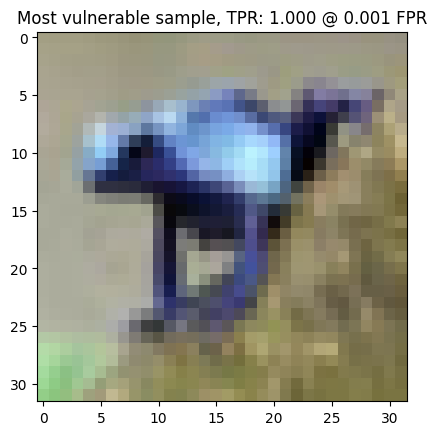

/tmp/ipykernel_21643/1110700184.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p_in, 'k', linewidth=2, color='lightblue', label='$\hat{Q}_{in}(x,y)$')
/tmp/ipykernel_21643/1110700184.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p_out, 'k', linewidth=2, color='orange', label='$\hat{Q}_{out}(x,y)$')


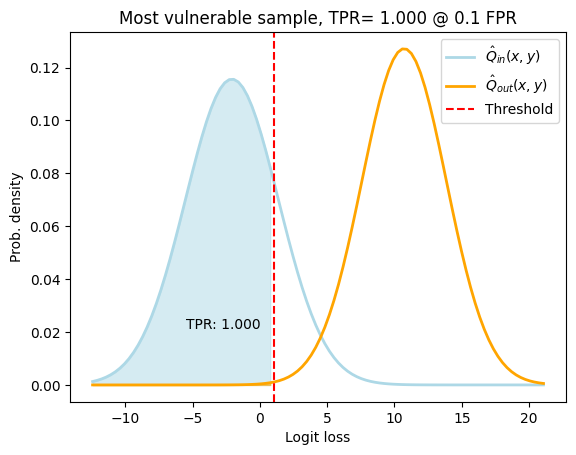

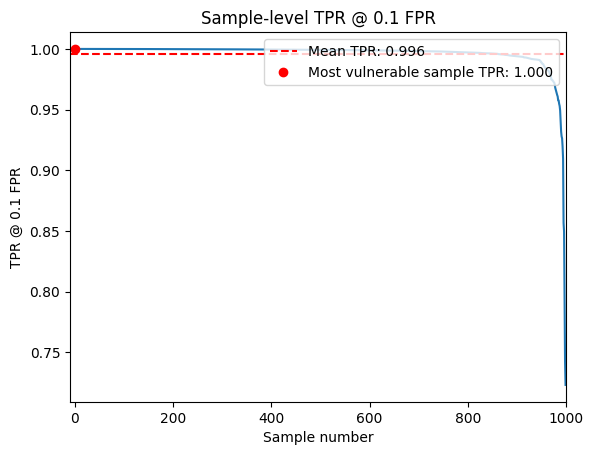

In [9]:
# show the most vulnerable sample
# get the index of the samples with the highest TPR (most vulnerable sample)

max_idx = max(priv_metrics.items(), key=lambda x: x[1][0])[0]
max_tpr, max_fpr, (mu_in, std_in), (mu_out, std_out) = priv_metrics[max_idx]

tprs = sorted([tpr for tpr, _, _, _ in priv_metrics.values()], reverse=True)
show_images(dataset_test[max_idx][0], f"Most vulnerable sample, TPR: {max_tpr:.3f} @ {max_fpr:.3f} FPR")
plot_logit_distributions(mu_in, std_in, mu_out, std_out, max_tpr)
plot_tprs(tprs, max_tpr)

# Differentially Private Training with DP-SGD

In [10]:
from opacus.validators import ModuleValidator
from opacus import PrivacyEngine
from opacus.utils.batch_memory_manager import BatchMemoryManager


def dp_train(training_data, epsilon, delta, max_grad_norm, batch_size, epochs, max_physical_batch_size=128, device=DEVICE):

    # Let us modify the model to work with Opacus. From the output above, you can see that the BatchNorm layers are not supported because 
    # they compute the mean and variance across the batch, creating a dependency between samples in a batch, a privacy violation.

    # Recommended approach to deal with it is calling ModuleValidator.fix(model) - it tries to find the best replacement for incompatible modules. 
    # For example, for BatchNorm modules, it replaces them with GroupNorm. You can see, that after this, no exception is raised

    dp_net = Net()
    dp_net = ModuleValidator().fix(dp_net)
    ModuleValidator.validate(dp_net)
    dp_net.to(device)

    optimizer = torch.optim.Adam(dp_net.parameters(), lr=0.001)
    privacy_engine = PrivacyEngine()
    dp_net.train()

    train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)

    dp_model, dp_optimizer, dp_train_loader = privacy_engine.make_private_with_epsilon(
        module=dp_net,
        optimizer=optimizer,
        data_loader=train_loader,
        epochs=epochs,
        target_epsilon=epsilon,
        target_delta=delta,
        max_grad_norm=max_grad_norm,
    )

    with BatchMemoryManager(
        data_loader=dp_train_loader,
        max_physical_batch_size=max_physical_batch_size,
        optimizer=dp_optimizer,
    ) as memory_safe_data_loader:
        train(dp_model, memory_safe_data_loader, epochs, criterion, device, dp_optimizer)

    return dp_model

### Normal and DP training (we use the training data to compare their performance)

In [11]:
MAX_GRAD_NORM = 1.2
EPSILON = 10.0
DELTA = 1 / len(dataset_train)
EPOCHS = 10

LR = 1e-3

# we use larger batch for DP training to compensate for the noise
BATCH_SIZE = 64
DP_BATCH_SIZE = 512
MAX_PHYSICAL_BATCH_SIZE = BATCH_SIZE


In [12]:
# Normal training 
net = Net()
net.to(DEVICE)

_train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
train(net, _train_loader, EPOCHS, criterion, device=DEVICE)
acc, loss = test(net, test_loader, criterion, device=DEVICE)
print(f"Test accuracy: {acc:.3f}")

# DP training
dp_net = dp_train(dataset_train, EPSILON, DELTA, MAX_GRAD_NORM, DP_BATCH_SIZE, EPOCHS, MAX_PHYSICAL_BATCH_SIZE, device=DEVICE)
acc, loss = test(dp_net, test_loader, criterion, device=DEVICE)
print(f"DP test accuracy: {acc:.3f}")


Training epoch 9: 100%|██████████| 790/790 [00:10<00:00, 78.62batch/s, accuracy=0.125, loss=0.0103]  
/home/melidon/Egyetem/msc/3_felev/a_gepi_tanulas_biztonsaga/gyakorlat/3_privacy/.venv/lib/python3.12/site-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/home/melidon/Egyetem/msc/3_felev/a_gepi_tanulas_biztonsaga/gyakorlat/3_privacy/.venv/lib/python3.12/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Test accuracy: 0.951


Training epoch 0:   0%|          | 0/780 [00:00<?, ?batch/s]/home/melidon/Egyetem/msc/3_felev/a_gepi_tanulas_biztonsaga/gyakorlat/3_privacy/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Training epoch 9: : 828batch [00:39, 20.79batch/s, accuracy=0.734, loss=0.677]                     


DP test accuracy: 0.862


## How to set $\varepsilon$? Best achievable TPR - FPR against DP for a given $\varepsilon$
(this is valid for any sample including canaries against the strongest attacker)

/tmp/ipykernel_21643/2510319792.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.clip(np.maximum(np.log((1-delta-fpr)/fnr),np.log((1-delta-fnr)/fpr)), 0, None)
/tmp/ipykernel_21643/2510319792.py:5: RuntimeWarning: invalid value encountered in log
  return np.clip(np.maximum(np.log((1-delta-fpr)/fnr),np.log((1-delta-fnr)/fpr)), 0, None)


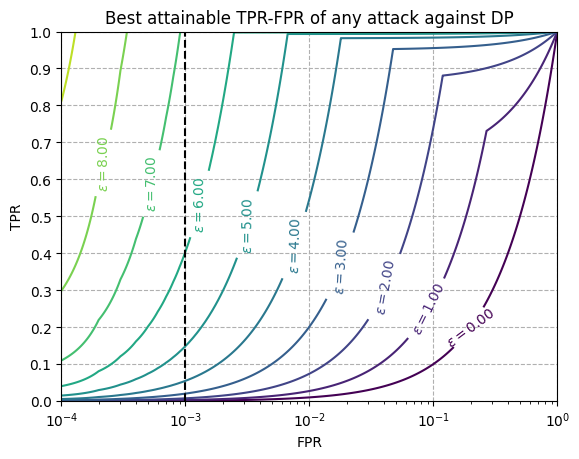

In [13]:
# plot an FPR-FNR curve
import matplotlib.pyplot as plt

def compute_eps(fnr, fpr, delta):
    return np.clip(np.maximum(np.log((1-delta-fpr)/fnr),np.log((1-delta-fnr)/fpr)), 0, None)

plt.figure()

# generate data
x = np.linspace(0, 1, 10000)

# make a color map where the color is eps and x axis is FPR and y axis in FNR
X, Y = np.meshgrid(x, x)
Z = compute_eps(1-Y, X, DELTA)
# get ax
ax = plt.gca()
# draw the contourlines
contour = ax.contour(X, Y, Z, levels=10)

# provide manual locations for labels
x = np.geomspace(0.0001, .2, 10)[1:]
y = np.linspace(0.7, 0.2, 10)[1:]
ax.clabel(contour, inline=True, fontsize=10, fmt='$\\varepsilon=$%1.2f', manual=zip(x,y))

# add lines for FPR=0.1 and FNR=0.1
plt.axvline(x=0.001, color='black', linestyle='--')

# logaritmic scale x-axis
plt.xscale('log')
plt.xlim(0.0001, 1)

plt.yticks(np.arange(0, 1.1, 0.1))

# add grids with dashed lines
plt.grid(linestyle='--')

#plt.colorbar()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Best attainable TPR-FPR of any attack against DP')
plt.show()
